In [1]:
# Basic imports
import os
import sys
sys.path.append("..")
from src.config import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import opensmile

# Preset Variables if needed:
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)
DATASET_PATH = os.path.join(CONFIG["paths"]["datasets"], "train_10000_ams.feather")

In [2]:
df = pd.read_feather(DATASET_PATH)
df["dataset_id"] = df["speaker_id"] + "_" + df["video_id"] + "_" + df["clip_id"]
df = df.set_index(["dataset_id", "speaker_id"])
df = df.dropna()
df.head()

,,face_id,gender,split,video_id,clip_id,batch,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,...,distance_16_08,distance_33_08,distance_00_27,distance_16_27,distance_04_08,distance_12_08,distance_60_64,distance_51_62,distance_57_66,distance_31_35
dataset_id,speaker_id,,,,,,,,,,,,,,,,,,,,,
id00012__raOc3-IRsw_00110,id00012,n000012,m,train,_raOc3-IRsw,00110,1,1.564974,0.003774,0.273585,0.916557,...,1.463315,0.741822,1.143794,1.130462,0.873205,0.864059,0.490037,0.067177,0.064329,0.265229
id00012__raOc3-IRsw_00114,id00012,n000012,m,train,_raOc3-IRsw,00114,1,1.748977,0.521542,0.575964,1.363831,...,1.488841,0.788406,1.154262,1.131495,0.863373,0.861859,0.467520,0.072253,0.071403,0.265667
id00012__raOc3-IRsw_00112,id00012,n000012,m,train,_raOc3-IRsw,00112,1,1.968397,0.009217,0.914747,1.066577,...,1.485398,0.779928,1.149290,1.128816,0.871123,0.870130,0.491795,0.069688,0.070287,0.273485
id00012__raOc3-IRsw_00111,id00012,n000012,m,train,_raOc3-IRsw,00111,1,1.596150,0.401869,0.953271,0.849894,...,1.464441,0.800565,1.125874,1.106447,0.852040,0.850530,0.455240,0.071137,0.071140,0.256185
id00012__raOc3-IRsw_00113,id00012,n000012,m,train,_raOc3-IRsw,00113,1,2.156229,0.441805,0.814727,0.954510,...,1.457218,0.776877,1.146347,1.127089,0.860801,0.856177,0.517907,0.068809,0.069081,0.275308


In [3]:
df["is_male"] = df["gender"].str.contains("m").astype(float)
df["is_male"].describe()

count    9954.000000
mean        0.803797
std         0.397143
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: is_male, dtype: float64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9954 entries, ('id00012__raOc3-IRsw_00110', 'id00012') to ('id00080_xKOKZLEReGo_00259', 'id00080')
Columns: 6600 entries, face_id to is_male
dtypes: float32(6373), float64(221), int64(1), object(5)
memory usage: 259.6+ MB


In [5]:
info_columns = [
    #"speaker_id",
    "face_id",
    "gender",
    "split",
    "video_id",
    "clip_id",
    "batch"
]
lm_columns = [
    c for c in df.columns if "landmark" in c
]
df = df.drop(columns = info_columns+lm_columns)

feature_columns = opensmile.Smile(FEATURE_SET, FEATURE_LEVEL).feature_names
label_columns = [c for c in df.columns if c not in feature_columns] # or AM_COLUMN_NAMES

In [6]:
test_speaker_ids = np.random.choice(df.index.get_level_values('speaker_id').unique(), size=10)
test_mask = df.index.get_level_values('speaker_id').isin(test_speaker_ids)
test_df = df[test_mask]
train_df = df[~test_mask]

y_test, y_train = test_df[label_columns], train_df[label_columns]
X_test, X_train = test_df.drop(columns=label_columns), train_df.drop(columns=label_columns)

In [7]:
AM_COLUMN_NAME = "distance_00_08"
y_test, y_train = y_test[AM_COLUMN_NAME], y_train[AM_COLUMN_NAME]

/tmp/ipykernel_30423/1182909572.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(target_data[:, i], col_data)[0]


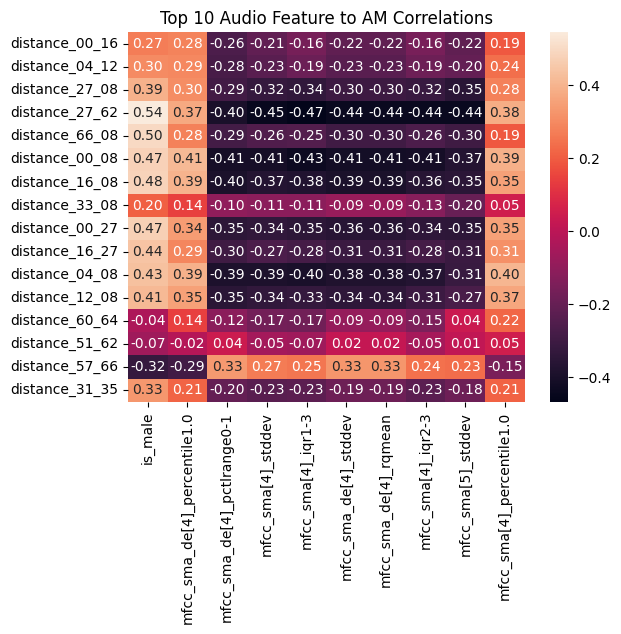

In [8]:
def calculate_target_correlations(df, target_columns):
    results = {}
    all_columns = df.columns
    target_data = df[target_columns].values
    
    for col in all_columns:
        if col not in target_columns:
            col_data = df[col].values
            correlations = [pearsonr(target_data[:, i], col_data)[0] 
                          for i in range(len(target_columns))]
            results[col] = correlations
    
    return pd.DataFrame(results, index=target_columns)

corr = calculate_target_correlations(test_df, AM_COLUMN_NAMES)
top_10_corr = list(corr.abs().sum().nlargest(10).index)
corr = corr[top_10_corr]
sns.heatmap(corr,annot=True, fmt=".2f")
plt.title("Top 10 Audio Feature to AM Correlations")
plt.show()

In [9]:
"""
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train.values), columns=X_train.columns)
X_test = pd.DataFrame(X_scaler.transform(X_test.values), columns=X_test.columns)

y_scaler = StandardScaler()
y_train = pd.DataFrame(y_scaler.fit_transform(pd.DataFrame(y_train)), columns=[AM_COLUMN_NAME])
y_test = pd.DataFrame(y_scaler.transform(pd.DataFrame(y_test)), columns=[AM_COLUMN_NAME])
"""

'\nfrom sklearn.preprocessing import StandardScaler\n\nX_scaler = StandardScaler()\nX_train = pd.DataFrame(X_scaler.fit_transform(X_train.values), columns=X_train.columns)\nX_test = pd.DataFrame(X_scaler.transform(X_test.values), columns=X_test.columns)\n\ny_scaler = StandardScaler()\ny_train = pd.DataFrame(y_scaler.fit_transform(pd.DataFrame(y_train)), columns=[AM_COLUMN_NAME])\ny_test = pd.DataFrame(y_scaler.transform(pd.DataFrame(y_test)), columns=[AM_COLUMN_NAME])\n'

In [10]:
y_train.describe()

count    7966.000000
mean        1.435509
std         0.048599
min         1.283770
25%         1.403384
50%         1.440245
75%         1.469981
max         1.624070
Name: distance_00_08, dtype: float64

In [11]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class AVG_MODEL:
    def __init__(self):
        self.mean_value = None
    
    def fit(self, X, y):
        self.mean_value = np.mean(y)
        return self
    
    def predict(self, X):
        if self.mean_value is None:
            raise ValueError("Model must be fitted before prediction")
        return np.full(X.shape[0], self.mean_value)

def evaluate_model(m_name: str, m):
    """Evaluate model performance on test data"""
    pred = m.predict(X_test)
    print(f"Evaluation for Model {m_name}:")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, pred):.4f}")
    print(f"Mean Squared Error : {mean_squared_error(y_test, pred):.4f}")
    print(f"R2 Score           : {r2_score(y_test, pred):.4f}")

def evaluate_neural_model(model):
    """
    Evaluate the trained neural network model
    """
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test.values)
        predictions = model(X_test_tensor).numpy()
    
    # Calculate metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print("Evaluation for Neural Network Model:")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Squared Error : {mse:.4f}")
    print(f"R2 Score           : {r2:.4f}")

In [12]:
avg_model = AVG_MODEL().fit(X_train, y_train)
evaluate_model("AVG_Model", avg_model)

Evaluation for Model AVG_Model:
Mean Absolute Error: 0.0481
Mean Squared Error : 0.0033
R2 Score           : -0.0478


In [13]:
class NeuralRegressionModel(nn.Module):
    def __init__(self, input_size=88, hidden_sizes=[128, 64, 32], dropout_rate=0.2):
        super(NeuralRegressionModel, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)
    
def train_neural_model(m, optimizer, criterion, epochs=1000, patience=50, batch_size=32):
    """
    Train the neural network model
    """
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train.values)
    y_train_tensor = torch.FloatTensor(y_train.values)
    X_val_tensor = torch.FloatTensor(X_test.values)
    y_val_tensor = torch.FloatTensor(y_test.values)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        m.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = m(batch_X).squeeze()
            loss = criterion(predictions, batch_y.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        m.eval()
        with torch.no_grad():
            val_predictions = m(X_val_tensor).squeeze()
            val_loss = criterion(val_predictions, y_val_tensor.squeeze())
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss.item())
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(m.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.6f}, Val Loss = {val_losses[-1]:.6f}")
    
    # Load best model
    m.load_state_dict(torch.load('best_model.pth'))
    return m, train_losses, val_losses

"""
nn_model = NeuralRegressionModel(input_size=X_train.shape[1], hidden_sizes=[128, 64, 32])
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.01, weight_decay=1e-5)

nn_model, _, _ = train_neural_model(nn_model, optimizer, criterion, patience=200, batch_size=64)
"""

nn_model = NeuralRegressionModel(input_size=X_train.shape[1], hidden_sizes=[512, 256, 128, 64, 32], dropout_rate=0.15)
criterion = nn.L1Loss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.01)

nn_model, _, _ = train_neural_model(nn_model, optimizer, criterion, patience=700, batch_size=512, epochs=5000)

Epoch 0: Train Loss = 0.570325, Val Loss = 1.635374
Epoch 50: Train Loss = 0.039614, Val Loss = 0.047684
Epoch 100: Train Loss = 0.038972, Val Loss = 0.047638
Epoch 150: Train Loss = 0.038882, Val Loss = 0.047710
Epoch 200: Train Loss = 0.038902, Val Loss = 0.047705
Epoch 250: Train Loss = 0.038930, Val Loss = 0.047709
Epoch 300: Train Loss = 0.038937, Val Loss = 0.047695
Epoch 350: Train Loss = 0.038945, Val Loss = 0.047710
Epoch 400: Train Loss = 0.038901, Val Loss = 0.047711
Epoch 450: Train Loss = 0.038930, Val Loss = 0.047703
Epoch 500: Train Loss = 0.038949, Val Loss = 0.047707
Epoch 550: Train Loss = 0.038891, Val Loss = 0.047701
Epoch 600: Train Loss = 0.038889, Val Loss = 0.047710
Epoch 650: Train Loss = 0.038924, Val Loss = 0.047716
Epoch 700: Train Loss = 0.038922, Val Loss = 0.047722
Early stopping at epoch 734


In [14]:
evaluate_neural_model(nn_model)

Evaluation for Neural Network Model:
Mean Absolute Error: 0.0473
Mean Squared Error : 0.0033
R2 Score           : -0.0415


In [15]:
import shap

explainer = shap.GradientExplainer(nn_model, torch.FloatTensor(X_train.values), batch_size=256)
nn_shap_values = explainer.shap_values(torch.FloatTensor(X_test.values))

/home/chr1s/.conda/envs/acoustic-to-anthropometric/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/tmp/ipykernel_30423/4176711325.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(nn_shap_values.squeeze(), X_test, feature_names=X_test.columns)


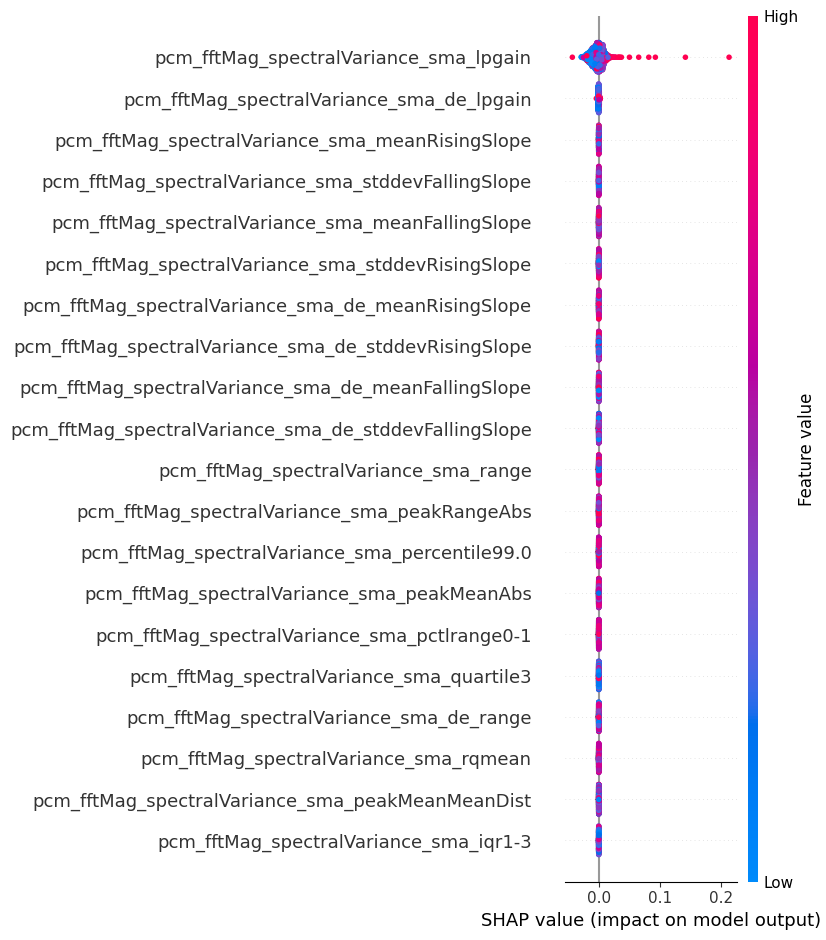

In [16]:
shap.summary_plot(nn_shap_values.squeeze(), X_test, feature_names=X_test.columns)